In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.__version__

'2.15.0'

In [4]:
!pip install requests


Defaulting to user installation because normal site-packages is not writeable


In [6]:
import requests

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
response = requests.get(url)

with open("helper_functions.py", "wb") as file:
    file.write(response.content)



In [7]:
from helper_functions import plot_loss_curves, walk_through_dir, make_confusion_matrix


In [8]:
df_norm = pd.read_excel('Normal.metadata.xlsx')
df_tb = pd.read_excel('Tuberculosis.metadata.xlsx')

In [9]:
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [11]:
df_norm['Tuberculosis'] = float(0)
df_tb['Tuberculosis'] = float(1)
df_norm.drop(columns=['FORMAT', 'SIZE', 'URL'], inplace=True)
df_tb.drop(columns=['FORMAT', 'SIZE', 'URL'], inplace=True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)


In [12]:
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [19]:
import os

ds = r"C:\Users\Mihir\Downloads\morwils\tb\TB_Chest_Radiography_Database"
SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')

# Count the images in each directory
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")


There are 3497 images of Normal.
There are 696 images of Tuberculosis.


In [20]:
def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal')
  os.makedirs(train_dir + '/Tuberculosis')
  os.makedirs(val_dir + '/Normal')
  os.makedirs(val_dir + '/Tuberculosis')
  os.makedirs(test_dir + '/Normal')
  os.makedirs(test_dir + '/Tuberculosis')
  os.makedirs(root_path + '/Images')

create_img_train_val_test_dirs('./')


In [21]:
IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

In [22]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')
    
  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)

    
split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    
    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')
    
    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)
    
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [23]:
len(os.listdir(IMAGE_DIR))

4193

In [24]:
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res

In [25]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [26]:
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [27]:
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4193


In [28]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

In [29]:
train_norm[:5]

['./training\\Normal\\Normal-10.png',
 './training\\Normal\\Normal-100.png',
 './training\\Normal\\Normal-1000.png',
 './training\\Normal\\Normal-1002.png',
 './training\\Normal\\Normal-1003.png']

Normal


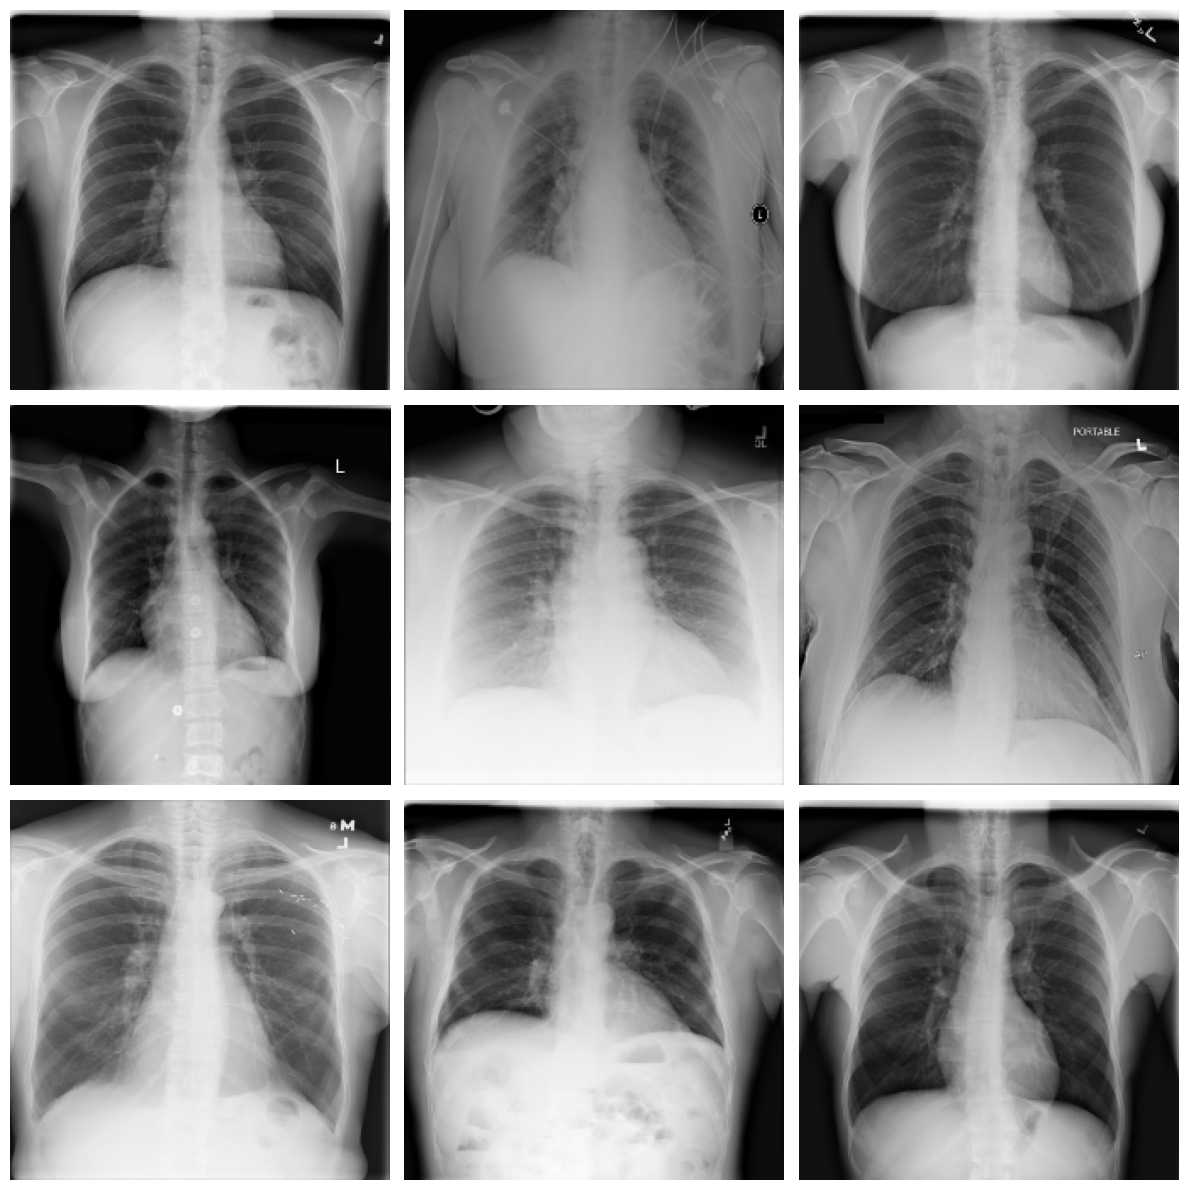

In [30]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Tuberculosis


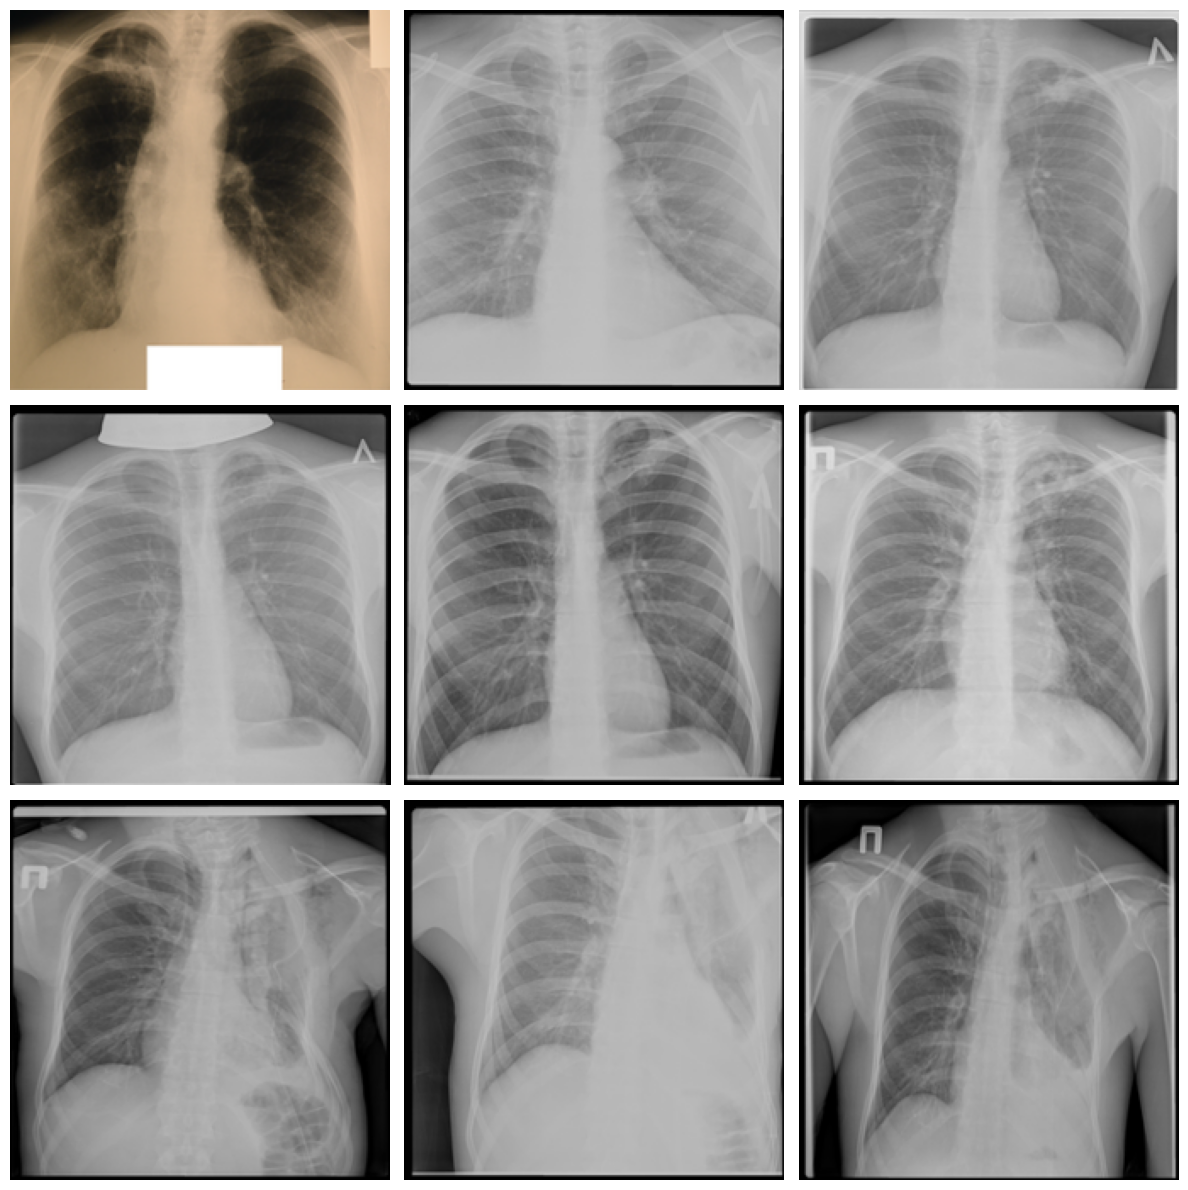

In [31]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [32]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.
    
    print("getting train generator...") 
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)
    
    # flow from directory with specified batch size
    # and target image size
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    
   
    return train_generator

In [33]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    # This computes the internal data stats related to the data-dependent transformations, based on an array of sample data.
    image_generator.fit(data_sample)
    # if we want to calculate the mean and std on the entire training dataset
    # image_generator.fit(raw_train_generator)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return val_generator, test_generator
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 3353 validated image filenames.
getting val and test generators...
Found 3353 validated image filenames.
Found 418 validated image filenames.
Found 422 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


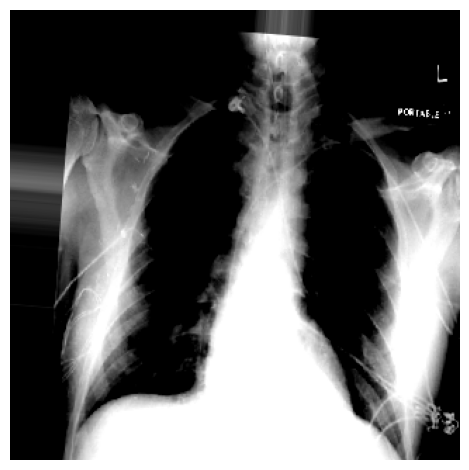

Image shape (320, 320, 3)


In [34]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)


In [35]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 19.878441186986056 %


In [36]:
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

In [37]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [38]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

In [39]:
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)
model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=["accuracy","AUC"])

In [40]:
checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )
#RLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 2, min_lr =0.001)
#ES = EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 2)

In [41]:
history = model.fit_generator(train_generator, 
                              validation_data=val_generator,
                              steps_per_epoch=100, 
                              validation_steps= 30,  
                              epochs = 3,
                              callbacks = [MC])

Epoch 1/3


100/100 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.8662 - auc: 0.9007
Epoch 1: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 192s 2s/step - loss: 0.1298 - accuracy: 0.8662 - auc: 0.9007 - val_loss: 2.4711 - val_accuracy: 0.8083 - val_auc: 0.5000
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.8913 - auc: 0.9520
Epoch 2: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 121s 1s/step - loss: 0.0849 - accuracy: 0.8913 - auc: 0.9520 - val_loss: 0.5605 - val_accuracy: 0.7667 - val_auc: 0.7333
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.8890 - auc: 0.9371
Epoch 3: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 119s 1s/step - loss: 0.0919 - accuracy: 0.8890 - auc: 0.9371 - val_loss: 0.2605 - val_accuracy: 0.9292 - val_auc: 0.9487


In [42]:
model = Model(inputs=base_model.input, outputs = output)
model.load_weights(checkpoint_path)

In [43]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


random.seed(a=None, version=2)
set_verbosity(INFO)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [44]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

In [45]:
y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       351
         1.0       0.84      0.68      0.75        71

    accuracy                           0.92       422
   macro avg       0.89      0.83      0.85       422
weighted avg       0.92      0.92      0.92       422

Accuracy of the Model: 92.41706161137441 %


In [46]:
y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)

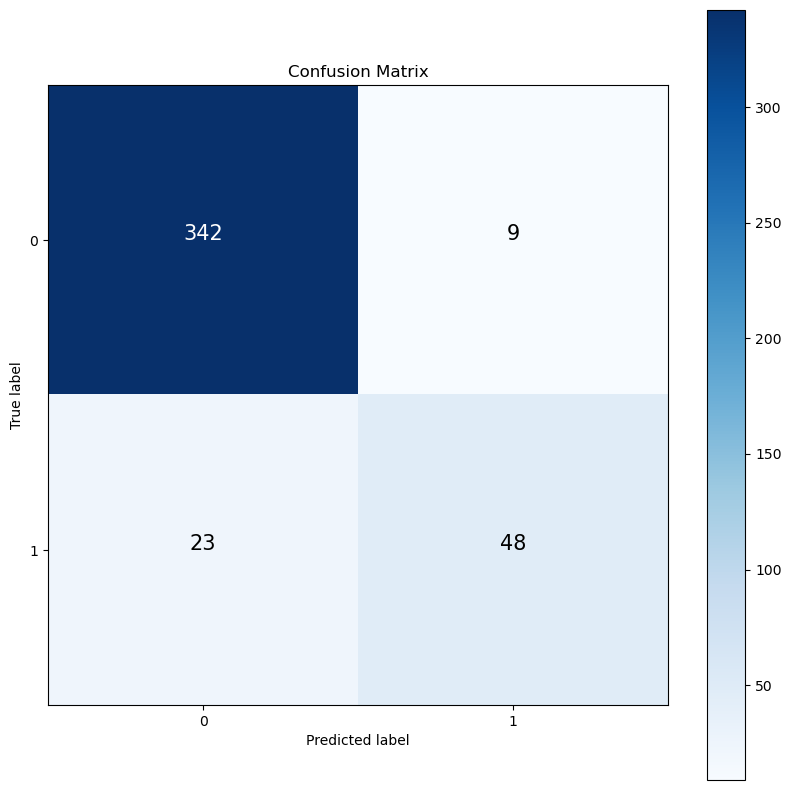

In [47]:
make_confusion_matrix(y_test, y_pred)

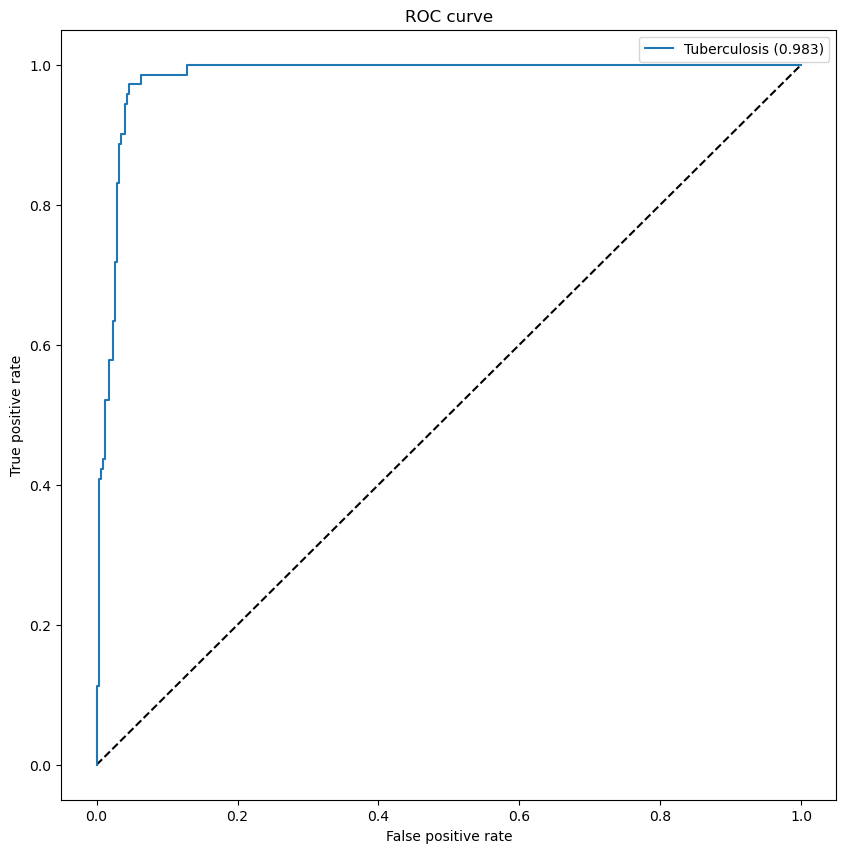

In [49]:
labels = ['Tuberculosis']
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [50]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(50)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
    return x

In [51]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)
# Sample 50 images for Batch normalization
imgs_path = []
for fn in test_df['Image'][:50]:
    full_path = IMAGE_DIR + '/' + fn
    imgs_path.append(full_path)

In [52]:
test = [load_image(i, IMAGE_DIR, test_df ) for i in imgs_path]
# convert to numpy array
test = np.array(test)
print(test.shape)

(50, 320, 320, 3)


In [53]:
preds = model.predict(test)
preds_ = np.where(preds > 0.5,1,0)
pos_pred = np.where(preds_.flatten() == 1)
n = pos_pred[0][0]
n

2/2 [==============================] - 3s 673ms/step


2

In [54]:
img_test = np.expand_dims(test[n], axis = 0)
preds = model.predict(img_test) 
i = np.where(preds > 0.5,1,0)

# Verify if prediction == 1
i.flatten()

1/1 [==============================] - 0s 125ms/step


array([1])

In [55]:
img_path = imgs_path[n]

In [56]:
icam = GradCAM(model, i, 'conv5_block16_1_conv') 
heatmap = icam.compute_heatmap(img_test)
heatmap = cv2.resize(heatmap, (320, 320))

image = cv2.imread(img_path)
image = cv2.resize(image, (320, 320))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(320, 320) (320, 320, 3)


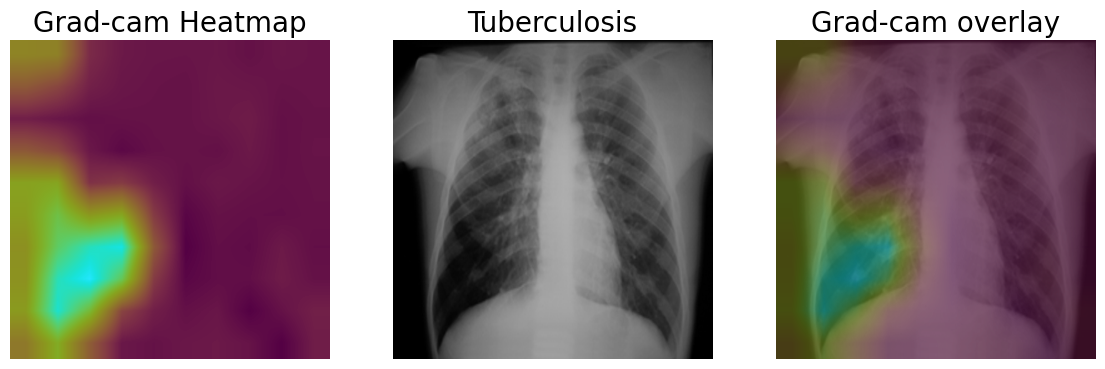

In [57]:
fig, ax = plt.subplots(1, 3, figsize = (14,14))

ax[0].imshow(heatmap)
ax[0].axis('Off')
ax[0].set_title('Grad-cam Heatmap', fontsize = 20)
ax[1].imshow(image)
ax[1].axis('Off')
ax[1].set_title('Tuberculosis', fontsize = 20)
ax[2].imshow(output)
ax[2].axis('Off')
ax[2].set_title('Grad-cam overlay', fontsize = 20)
fig.show()